In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [2]:

# Load the data
df = pd.read_csv('/home/tom/Python/Machine learning/pytorch/xauusd/XAU_USD Historical Data.csv' , thousands=',')

# Extract 'Date' and 'Price' columns (swap 'Price' and 'Open' columns)
df = df[['Date', 'Price', 'Open']]
# Convert 'Date' to datetime and sort by date
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df

,Date,Price,Open
5991,2000-12-25,274.05,274.00
5990,2000-12-26,274.45,273.40
5989,2000-12-27,275.55,274.55
5988,2000-12-28,272.55,275.25
5987,2000-12-29,272.40,272.45
...,...,...,...
4,2023-12-22,2052.98,2045.84
3,2023-12-25,2054.93,2054.32
2,2023-12-26,2067.20,2055.73
1,2023-12-27,2079.57,2066.26


In [3]:
# Normalize the 'Price' and 'Open' values (swap 'Price' and 'Open' columns)
scaler = MinMaxScaler()

df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))
df['Open'] = scaler.fit_transform(df['Open'].values.reshape(-1, 1))

# Convert the DataFrame to a PyTorch tensor and add one additional dimension
features = torch.tensor(df[['Price', 'Open']].values.astype(np.float32)).unsqueeze(-1)


In [4]:
#This block is purely for testing
for x, y in features:
    y_inverse = scaler.inverse_transform(y.view(-1, 1)).flatten()
    x_inverse = scaler.inverse_transform(x.view(-1, 1)).flatten()
    # Print or use the non-normalized values as needed
    #print("Original values price and :", y_inverse, x_inverse)


In [5]:
# Define a function to create input sequences and corresponding targets
def create_sequences_open(data, seq_length):
    sequences_features = []
    sequences_open = []
    targets_open = []

    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length, :]
        sequence_features = seq[:, :]  # All features
        sequence_open = seq[-1, 1]   # 'Open' column at index 1 of the last time step
        target_open = data[i+seq_length, 1]  # Next 'Open' value

        sequences_features.append(sequence_features)
        sequences_open.append(sequence_open)
        targets_open.append(target_open)

    return (
        torch.stack(sequences_features).squeeze(), # remove extra dimension
        torch.stack(sequences_open),
        torch.stack(targets_open)
    )

In [6]:
# Define a function to create input sequences and corresponding targets
def create_sequences_price(data, seq_length):
    sequences_features = []
    sequences_open = []
    targets_open = []

    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length, :]
        sequence_features = seq[:, :]  # All features
        sequence_open = seq[-1, 0]   # 'Open' column at index 1 of the last time step
        target_open = data[i+seq_length, 0]  # Next 'Open' value

        sequences_features.append(sequence_features)
        sequences_open.append(sequence_open)
        targets_open.append(target_open)

    return (
        torch.stack(sequences_features).squeeze(), # remove extra dimension
        torch.stack(sequences_open),
        torch.stack(targets_open)
    )

In [32]:
# Define hyperparameters
sequence_length = 20
batch_size = 64
epochs = 200
learning_rate = 0.001


In [33]:
# Create sequences and targets
sequences_features, sequences_open, targets_open = create_sequences_open(features, sequence_length)

#sequences_open = sequences_open.unsqueeze(-1)
#targets_open = targets_open.unsqueeze(-1)

# Split the data into training and testing sets
split_ratio = 0.99
split_index = int(split_ratio * len(sequences_open))

train_sequences_features, test_sequences_features = sequences_features[:split_index], sequences_features[split_index:]
train_sequences_open, test_sequences_open = sequences_open[:split_index], sequences_open[split_index:]
train_targets_open, test_targets_open = targets_open[:split_index], targets_open[split_index:]


In [34]:
# Create sequences and targets
sequences_features, sequences_price, targets_price = create_sequences_price(features, sequence_length)

#sequences_price = sequences_price.unsqueeze(-1)
#targets_price = targets_price.unsqueeze(-1)

# Split the data into training and testing sets
split_ratio = 0.99
split_index = int(split_ratio * len(sequences_price))

train_sequences_features, test_sequences_features = sequences_features[:split_index], sequences_features[split_index:]
train_sequences_price, test_sequences_price = sequences_price[:split_index], sequences_price[split_index:]
train_targets_price, test_targets_price = targets_price[:split_index], targets_price[split_index:]


In [35]:
print('shape of features sequeneces', sequences_features.shape)
print('shape of open sequences', sequences_open.shape)
print('shape of open targets', targets_open.shape)

shape of features sequeneces torch.Size([5972, 20, 2])
shape of open sequences torch.Size([5972, 1])
shape of open targets torch.Size([5972, 1])


In [36]:
# Create DataLoader for training
train_dataset_open = TensorDataset(train_sequences_features, train_targets_open)
train_dataloader_open = DataLoader(train_dataset_open, batch_size=batch_size, shuffle=True)

# Test the model on the testing set
test_dataset_open = TensorDataset(test_sequences_features, test_targets_open)
test_dataloader_open = DataLoader(test_dataset_open, batch_size=batch_size, shuffle=False)

In [37]:
# Create DataLoader for training
train_dataset_price = TensorDataset(train_sequences_features, train_targets_price)
train_dataloader_price = DataLoader(train_dataset_price, batch_size=batch_size, shuffle=True)

# Test the model on the testing set
test_dataset_price = TensorDataset(test_sequences_features, test_targets_price)
test_dataloader_price = DataLoader(test_dataset_price, batch_size=batch_size, shuffle=False)


In [38]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=100, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [39]:
# Assuming you have the inverse scaler_open available
inverse_scaler = scaler.inverse_transform

# Iterate over the dataset
for inputs, targets in test_dataloader_open:
    # Assuming inputs is a tensor with shape (batch_size, sequence_length, num_features)
    # and targets is a tensor with shape (batch_size, 1)

    # Extract the non-normalized 'Open' values
    non_normalized_open_sequence = inverse_scaler(inputs[:, -1, 0].view(-1, 1)).flatten()
    non_normalized_open_target = inverse_scaler(targets[:, -1].view(-1, 1)).flatten()


    # Print or use the non-normalized values as needed
    #print("Non-normalized 'Open' values:", non_normalized_open_sequence)


In [40]:
# Instantiate the model
model_open = LSTMModel(input_size=2)

# Define loss and optimizer for 'Open'
criterion_open = nn.MSELoss()
optimizer_open = torch.optim.Adam(model_open.parameters(), lr=learning_rate)

# Train the model
for epoch in range(epochs):
    for batch_seq, batch_target in train_dataloader_open:
        optimizer_open.zero_grad()
        output_open = model_open(batch_seq)
        loss_open = criterion_open(output_open, batch_target)
        loss_open.backward()
        optimizer_open.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss Open: {loss_open.item()}')


Epoch 1/200, Loss Open: 0.0006499418523162603
Epoch 2/200, Loss Open: 0.00020416102779563516
Epoch 3/200, Loss Open: 0.0001133584082708694
Epoch 4/200, Loss Open: 5.728151882067323e-05
Epoch 5/200, Loss Open: 0.00012039046850986779
Epoch 6/200, Loss Open: 6.694850890198722e-05
Epoch 7/200, Loss Open: 5.904064164496958e-05
Epoch 8/200, Loss Open: 0.00013594845950137824
Epoch 9/200, Loss Open: 0.00022609836014453322
Epoch 10/200, Loss Open: 0.00014533403737004846
Epoch 11/200, Loss Open: 0.00011009698937414214
Epoch 12/200, Loss Open: 0.0001887612306745723
Epoch 13/200, Loss Open: 0.00015576626174151897
Epoch 14/200, Loss Open: 0.00010583648690953851
Epoch 15/200, Loss Open: 7.339537842199206e-05
Epoch 16/200, Loss Open: 0.00024291173031087965
Epoch 17/200, Loss Open: 0.00011975502275163308
Epoch 18/200, Loss Open: 0.00011592579539865255
Epoch 19/200, Loss Open: 3.127099625999108e-05
Epoch 20/200, Loss Open: 0.00012245857215020806
Epoch 21/200, Loss Open: 2.6124902433366515e-05
Epoch 22/

In [41]:
# Instantiate the model
model_price = LSTMModel(input_size=2)

# Define loss and optimizer for 'Price'
criterion_price = nn.MSELoss()
optimizer_price = torch.optim.Adam(model_price.parameters(), lr=learning_rate)

# Train the model
for epoch in range(epochs):
    for batch_seq, batch_target in train_dataloader_price:
        optimizer_price.zero_grad()
        output_price = model_price(batch_seq)
        loss_price = criterion_price(output_price, batch_target)
        loss_price.backward()
        optimizer_price.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss price {loss_price.item()}')


Epoch 1/200, Loss price 0.000196871769730933
Epoch 2/200, Loss price 0.0002773489977698773
Epoch 3/200, Loss price 0.00024902616860345006
Epoch 4/200, Loss price 0.00020323168428149074
Epoch 5/200, Loss price 0.00011230245581828058
Epoch 6/200, Loss price 0.00039839278906583786
Epoch 7/200, Loss price 0.0001105536357499659
Epoch 8/200, Loss price 0.0003982377238571644
Epoch 9/200, Loss price 8.571211219532415e-05
Epoch 10/200, Loss price 0.00030431326013058424
Epoch 11/200, Loss price 7.30491301510483e-05
Epoch 12/200, Loss price 0.00016016759036574513
Epoch 13/200, Loss price 0.00018148589879274368
Epoch 14/200, Loss price 0.00013628702436108142
Epoch 15/200, Loss price 9.349047468276694e-05
Epoch 16/200, Loss price 0.00010215843940386549
Epoch 17/200, Loss price 3.9329141145572066e-05
Epoch 18/200, Loss price 0.00011516568338265643
Epoch 19/200, Loss price 0.0001104682742152363
Epoch 20/200, Loss price 0.0002448860032018274
Epoch 21/200, Loss price 0.00013932665751781315
Epoch 22/200

In [43]:
# Define future_dates before making predictions
df['Date'] = pd.to_datetime(df['Date'])
future_dates = pd.date_range(start=df['Date'].max(), periods=10)[1:]


with torch.no_grad():
    # Get the last 10 (sequence length) entries from open and price columns (features)
    future_values_features = features[-sequence_length:, :].clone().squeeze()
    predicted_values_open = []

    for i in range(10):  

        # Get the last 10 (sequence length) entries from open and price columns (features + predicted features so far in the loop)
        input_sequence_features = future_values_features[-sequence_length:].view(1, -1, 2)
        prediction_open = model_open(input_sequence_features)
        prediction_price = model_price(input_sequence_features)

        # Concatenate along the second dimension
        combined_predictions = torch.cat((prediction_open, prediction_price), dim=1)

        # Append the predicted value to the list
        predicted_values_open.append(prediction_open.item())
        #print('shape of combined_predictions and future_values_features are', combined_predictions.shape, future_values_features.shape)

        # Update future_values_features by appending the predicted_open value
        # Flatten the combined_predictions to make it 1D before concatenation
        future_values_features = torch.cat([future_values_features, combined_predictions.flatten().unsqueeze(0)], dim=0)

# Inverse transform the predicted values
predicted_values_open = scaler.inverse_transform(torch.tensor(predicted_values_open).view(-1, 1)).flatten()

# Check and adjust lengths
min_length_open = min(len(future_dates), len(predicted_values_open))
future_dates = future_dates[:min_length_open]

# Create DataFrame for the predicted values
predicted_df_open = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Open': predicted_values_open[:min_length_open]
})

# Print the predicted DataFrame
print(predicted_df_open)


        Date  Predicted_Open
0 2023-12-29     2082.257237
1 2023-12-30     2083.172847
2 2023-12-31     2083.295697
3 2024-01-01     2083.245905
4 2024-01-02     2083.194590
5 2024-01-03     2083.173717
6 2024-01-04     2083.187633
7 2024-01-05     2083.230467
8 2024-01-06     2083.293305


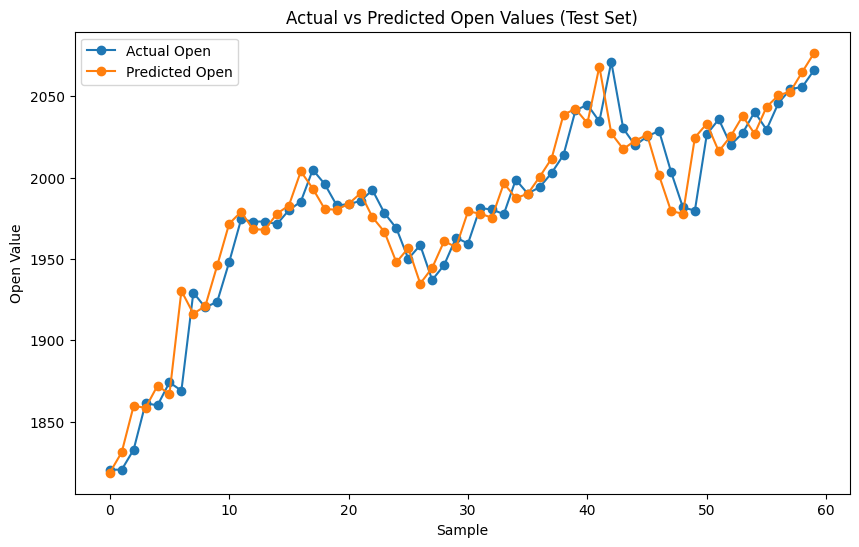

In [47]:
# Make predictions on the test set
with torch.no_grad():
    test_predictions_open = []

    for batch_seq, _ in test_dataloader_open:
        prediction_open = model_open(batch_seq)
        test_predictions_open.append(prediction_open)

# Concatenate the predictions for the entire test set
test_predictions_open = torch.cat(test_predictions_open).view(-1)

# Inverse transform the predicted values
predicted_values_open = scaler.inverse_transform(test_predictions_open.view(-1, 1)).flatten()
test_sequences_open_new = scaler.inverse_transform(test_sequences_open.view(-1, 1)).flatten()

# Plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(test_sequences_open_new, label='Actual Open', marker='o')
plt.plot(predicted_values_open, label='Predicted Open', marker='o')
plt.title('Actual vs Predicted Open Values (Test Set)')
plt.xlabel('Sample')
plt.ylabel('Open Value')
plt.legend()
plt.show()

#print(predicted_values_open)

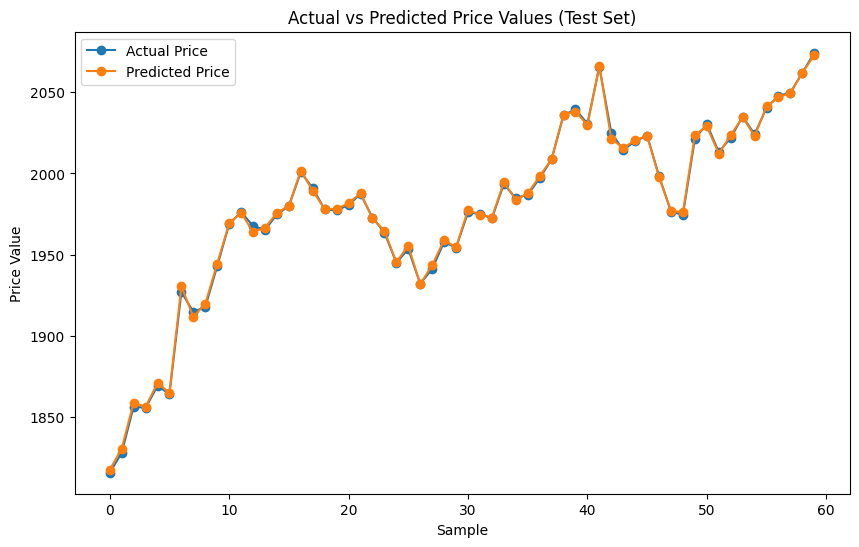

In [48]:
# Make predictions on the test set
with torch.no_grad():
    test_predictions_price = []

    for batch_seq, _ in test_dataloader_price:
        prediction_price = model_price(batch_seq)  # Assuming the model for price predictions is named model_price
        test_predictions_price.append(prediction_price)

# Concatenate the predictions for the entire test set
test_predictions_price = torch.cat(test_predictions_price).view(-1)

# Inverse transform the predicted values
predicted_values_price = scaler.inverse_transform(test_predictions_price.view(-1, 1)).flatten()
test_sequences_price_new = scaler.inverse_transform(test_sequences_price.view(-1, 1)).flatten()

# Plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(test_sequences_price_new, label='Actual Price', marker='o')
plt.plot(predicted_values_price, label='Predicted Price', marker='o')
plt.title('Actual vs Predicted Price Values (Test Set)')
plt.xlabel('Sample')
plt.ylabel('Price Value')
plt.legend()
plt.show()
#print(predicted_values_price)